In this project we wanted to search the connection between the nutrition values on a food product to their price.
of course we know that there are more things that affects the price of a certain product, but in this project we'll look only at the nutrition values of the products

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.pylab as plta
import matplotlib.ticker as ticker

import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error as MSE

plt.style.use('seaborn')

In [2]:
df = pd.read_csv (r'C:\אריאל\שנה א\סמסטר א\מבוא למדעי הנתונים\עבודת הגמר\Data_Science_intro_project\Regression\data_converted_to_english.csv', index_col = False)

In [3]:
df.head()

,Product_Name,1_kg,Vitamin_B1,Vitamin_B6,Dietary_fiber,Folic_acid,energy,Proteins,Carbohydrates,Fats,...,chromium,Molybdenum,1_meter,100_meters,Unsaturated,Acidic_acid,Linoleic_acid,DHA,EPA,Chlorophyll
0,clementine,5.9,0.09,0.08,1.7,24.0,47.0,9.0,12.0,0.2,...,0,0,0,0,0,0,0,0,0,0
1,Gilded_apple,10.9,0.00,0.00,2.4,0.0,52.0,0.3,13.8,0.2,...,0,0,0,0,0,0,0,0,0,0
2,lemon,6.9,0.00,0.08,2.8,0.0,29.0,1.1,9.3,0.3,...,0,0,0,0,0,0,0,0,0,0
3,Orange_in_the_juice_network,4.9,0.09,0.06,2.5,39.0,49.0,1.0,11.9,0.3,...,0,0,0,0,0,0,0,0,0,0
4,Avocado,9.9,0.07,0.30,6.7,81.0,160.0,2.0,8.5,14.7,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9586 entries, 0 to 9585
Columns: 105 entries, Product_Name to Chlorophyll
dtypes: float64(27), int64(74), object(4)
memory usage: 7.7+ MB


In [5]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state=42)

In [6]:
prod = train_set.copy()

In [7]:
prod.replace('(^\s+|\s+$)', '', regex=True, inplace=True)
prod= prod.set_index('Product_Name')

In [8]:
for col in prod.columns:  
    prod[col] = pd.to_numeric(prod[col], errors='coerce')
prod = prod.fillna(0)
sts_dropped_collumns = np.transpose(prod.loc[:, (prod == 0).all(axis=0)]).index
prod = prod.loc[:, (df != 0).any(axis=0)]

In [9]:
prod.loc['The_best_yellow_lite_9%',:].head(30)

1_kg                         0.0
Vitamin_B1                   0.0
Vitamin_B6                   0.0
Dietary_fiber                2.0
Folic_acid                   0.0
energy                     197.0
Proteins                    21.0
Carbohydrates                8.0
Fats                         9.0
sodium                     840.0
Vitamin_B3                   0.0
potassium                    0.0
Vitamin_C                    0.0
iron                         0.0
1_unit                       0.0
100_g                        5.9
Vitamin_B2                   0.0
Vitamin_K.                   0.0
Vitamin_E.                   0.0
Magnesium                    0.0
Carbohydrate_sugars          0.0
Vitamin_A                    0.0
Dietary_fiber.1              0.0
zinc                         0.0
Of_which_added_sugar         0.0
100_ml                       0.0
Of_which_saturated_fat       3.0
Trans_fatty_acids            0.0
Teaspoons_of_sugar           0.0
calcium                   1000.0
Name: The_

In [10]:
prod.calcium.mean()

52.382261345852896

In [11]:
prod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7668 entries, Belgian_lemon-flavored_waffle_for_school to Gluten-free_seed_baguette
Data columns (total 98 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   1_kg                                 7668 non-null   float64
 1   Vitamin_B1                           7668 non-null   float64
 2   Vitamin_B6                           7668 non-null   float64
 3   Dietary_fiber                        7668 non-null   float64
 4   Folic_acid                           7668 non-null   float64
 5   energy                               7668 non-null   float64
 6   Proteins                             7668 non-null   float64
 7   Carbohydrates                        7668 non-null   float64
 8   Fats                                 7668 non-null   float64
 9   sodium                               7668 non-null   float64
 10  Vitamin_B3                           7668

### After a brief look at the cloumns we have, we pointed out a couple of things nedded to be done:
##### get rid of the unwanted units we have:
we want all the get rif of all the products that are not measured by 100_g or 1_kg (and delete the columns of these units).
afterwards, we need to unite the 100_g and 1_kg units (by deviding 1_kg by 10 we'll get the price for 100_g)
#### we'll check which columns left, and with them:
##### unite the columns:
- DHA_fatty_acid and DHA 
- Vitamin_A and Vitamin_A_is_worth_retinol 
- Dietary_fiber and Dietary_fiber.1 
- Potassium and K_Potassium (two different names to the same thing)
- Vitamin_E_equals_alpha_tocopherol and Vitamin_E. (When referring generally to vitamin E, it is therefore related to the alpha-tocopherol form https://www.wikirefua.org.il/w/index.php/%D7%95%D7%99%D7%98%D7%9E%D7%99%D7%9F_-_Vitamin_-_E )
- Niacin, Vitamin_B3_Nicotinamide_Equilibrium and Vitamin_b3 (they are reffering to the same thing: https://en.wikipedia.org/wiki/Niacin)
- DHA and EPA with DHA_+_EPA (?)

##### look at a features we suspect may have high correlation:
- Vitamin b's group
- all the things that contains sugars
- Carbohydrate_sugars and Carbohydrate
- correlations with energy (energy, which is calories, can come from many different features)
- the many kinds of fat
- DHA and EPA with DHA_+_EPA (?)

In [12]:
#first, we'll find the products without the wanted price units 
unwanted_units = prod[(prod['100_g']==0) & (prod['1_kg']==0)].index
print(unwanted_units)
#moreover, we'll check if there are any products with more than one wanted price units 
print(prod[(prod['100_g']!=0) & (prod['1_kg']!=0)].index)
#we'll notice that there are 807 products without the wanted price units and remove them
prod = prod.drop(unwanted_units) #dropes products with unwanted units
all_dropped_collumns = np.transpose(prod.loc[:, (prod == 0).all(axis=0)]).index
prod = prod.loc[:, (prod != 0).any(axis=0)] #deletes all columns with all values set to zero, such as columns of units that are not 100_g or 1_kg 
prod['1_kg'] = prod['1_kg']/10
prod['price_per_100g'] = prod['1_kg'] + prod['100_g']
prod = prod.drop(['100_g' ,'1_kg'], axis=1)

Index(['Milk_in_a_3%_fat_carton', '5%_Organic_White_Wine_Vinegar',
       'Grape_seed_oil', 'Alpero_Almond_Coconut_Drink', 'Ice_snacks',
       '22%_gluten-free_coconut_cream', 'Thai_sauce_Pad_Thai',
       'Solgar_Super_Gala_300', 'Sweet_chili_sauce', 'Organic_coconut_oil',
       ...
       'Wholemeal_bun_case', 'Soy_drink_for_LS_Alpro',
       'Coffee-flavored_soy_drink', 'Alpro_Chocolate_Soy_Drink', 'Magnox_520',
       'Coconut_cream_20-22%', 'Sweet_and_sour_sauce',
       'Organic_apple_cider_vinegar_5%', 'Donuts_cocoa_cream_+_candies',
       'Natural_apple_juice'],
      dtype='object', name='Product_Name', length=807)
Index([], dtype='object', name='Product_Name')


In [13]:
all_dropped_collumns

Index(['1_unit', '100_ml', '1_cm', 'DHA_+_EPA', 'Trans_fat', 'Acetic_acid',
       'Unsaturated', 'Acidic_acid', 'Linoleic_acid', 'DHA', 'EPA',
       'Chlorophyll'],
      dtype='object')

noticed that DHA, EPA and DHA_+_EPA collumns fell in the filtering we did. Thus, these are the things we wanted to do and the ones we left with:
##### unite the columns:
~~- DHA_fatty_acid and DHA~~ 
- Vitamin_A and Vitamin_A_is_worth_retinol
- Dietary_fiber and Dietary_fiber.1
- Potassium and K_Potassium
- Vitamin_E_equals_alpha_tocopherol and Vitamin_E.
- Niacin, Vitamin_B3_Nicotinamide_Equilibrium and Vitamin_b3

~~- DHA and EPA with DHA_+_EPA (?)~~

##### look at a features we suspect may have high correlation:
- Vitamin b's group
- all the things that contains sugars
- Carbohydrate_sugars and Carbohydrate
- correlations with energy (energy, which is calories, can come from many different features)
- the many kinds of fat

~~- DHA and EPA with DHA_+_EPA (?)~~

Before we continued to work with the data, we wanted to scale the data in order to avoid any problems that might come with nutrition values that are measured by different units. We wanted to scale only the products and not the prices, so we splitted the prices from the nutrition values and then did the scaling. But before that we created another another train and test set based on how many products has values in each column, beacuse logicly, the nutrition values we have more can help us predict the price to a wider range of products.

In [14]:
products_notscaled = prod.drop("price_per_100g", axis=1)
prices = prod["price_per_100g"].copy()

### creating another data set:

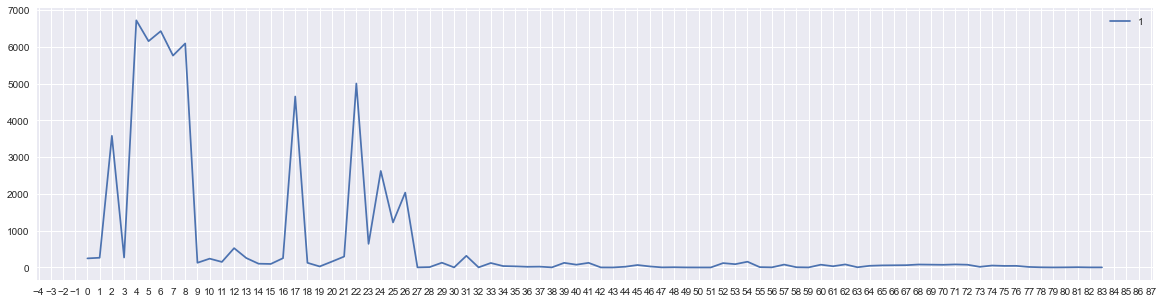

In [15]:
df_num = []
df_name = []
for col in products_notscaled.columns:
    df_num.append(int(products_notscaled[col].astype(bool).sum(axis=0)))
    df_name.append(col)
df2 = pd.DataFrame([df_name, df_num]).transpose()
ax = df2.plot(x_compat=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator()) #Dynamically finds major tick positions
plta.gcf().set_size_inches(20, 5)
plta.show() #in order to check which features can be given up
#it seems that starting from feature number 26, we can give up on those features
#it actually makes sense, because when we did the web scraping, it added to the keys, the names of the columns, 
#a name each time it was not already there. therefore, we would expect the common keys to be at the beginning of the columns

we can see from the graph that the mass of products we have with more than 1000 non-zero values is between columns 2 to 26. Based on that, we created a new data set of only these features and the price columns. (the reason we decided not to take specific columns is in order to prevent doing over fitting)

In the end, when we tried to run the models we decided what kind of filltering is the most worthy, and which features are better for predictions (what feature selection we should do)

In [16]:
products_notscaled2 = products_notscaled.iloc[:,2:26] 
prices2 = prices
products_notscaled2

,Dietary_fiber,Folic_acid,energy,Proteins,Carbohydrates,Fats,sodium,Vitamin_B3,potassium,Vitamin_C,...,Magnesium,Carbohydrate_sugars,Vitamin_A,Dietary_fiber.1,zinc,Of_which_added_sugar,Of_which_saturated_fat,Trans_fatty_acids,Teaspoons_of_sugar,calcium
Product_Name,,,,,,,,,,,,,,,,,,,,,
Belgian_lemon-flavored_waffle_for_school,0.00,0.00,89.00,0.80,9.20,6.30,17.5,0.0,0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,3.30,0.00,0.00,0.0
Pasta_Perfecto_Casserole,1.60,0.00,160.00,0.00,0.00,0.00,0.0,0.0,0,0.0,...,0,1.4,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
Whole_champignon_mushrooms,2.20,0.00,18.00,2.10,0.90,0.00,240.0,0.0,0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
Light_bread_from_whole_spelled,2.45,0.00,38.88,3.07,8.46,0.39,86.9,0.0,0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.12,0.00,0.00,0.0
Baby_bite_flavored_vegetables,0.00,0.00,8.00,0.00,2.00,0.00,6.0,0.0,0,0.0,...,0,0.3,0.0,0.0,0.0,0.0,0.10,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Epic_Cola_Candy,0.00,0.00,335.00,6.30,76.00,0.00,0.0,0.0,0,0.0,...,0,45.0,0.0,0.0,0.0,0.0,0.00,0.00,11.25,0.0
Slim_Delis_Multi-Grain_Milk,1.60,7.22,59.00,0.80,7.40,2.60,36.4,0.7,0,0.0,...,0,4.4,34.5,0.0,0.0,0.0,1.40,0.00,8.75,0.0
Chocolate_with_popsicles,0.00,0.00,516.00,8.10,58.00,27.00,117.0,0.0,0,0.0,...,0,57.0,0.0,0.0,0.0,0.0,16.50,0.00,14.25,0.0


In [17]:
scaler = StandardScaler()

scaler.fit(products_notscaled2)
productsarr2 = scaler.transform(products_notscaled2) #scaler returns numpy array
products2 = pd.DataFrame(productsarr2, index=products_notscaled2.index, columns=products_notscaled2.columns)




scaler.fit(products_notscaled)
productsarr = scaler.transform(products_notscaled) #scaler returns numpy array
products = pd.DataFrame(productsarr, index=products_notscaled.index, columns=products_notscaled.columns)

In [18]:
products

,Vitamin_B1,Vitamin_B6,Dietary_fiber,Folic_acid,energy,Proteins,Carbohydrates,Fats,sodium,Vitamin_B3,...,Alpha_linolenic_acid,chlorine,Carnitine,Chloride,AA_fatty_acid,Vitamin_B3_Nicotinamide_Equilibrium,K_Potassium,humidity,chromium,Molybdenum
Product_Name,,,,,,,,,,,,,,,,,,,,,
Belgian_lemon-flavored_waffle_for_school,-0.017165,-0.080165,-0.575911,-0.044397,-1.001195,-0.425699,-0.730628,-0.424929,-0.192885,-0.089007,...,-0.053273,-0.059642,-0.063393,-0.044047,-0.027049,-0.016771,-0.019918,-0.033388,-0.020289,-0.020924
Pasta_Perfecto_Casserole,-0.017165,-0.080165,-0.206156,-0.044397,-0.600002,-0.472755,-1.039895,-0.850633,-0.199101,-0.089007,...,-0.053273,-0.059642,-0.063393,-0.044047,-0.027049,-0.016771,-0.019918,-0.033388,-0.020289,-0.020924
Whole_champignon_mushrooms,-0.017165,-0.080165,-0.067498,-0.044397,-1.402388,-0.349234,-1.009641,-0.850633,-0.113853,-0.089007,...,-0.053273,-0.059642,-0.063393,-0.044047,-0.027049,-0.016771,-0.019918,-0.033388,-0.020289,-0.020924
Light_bread_from_whole_spelled,-0.017165,-0.080165,-0.009724,-0.044397,-1.284403,-0.292179,-0.755504,-0.824280,-0.168234,-0.089007,...,-0.053273,-0.059642,-0.063393,-0.044047,-0.027049,-0.016771,-0.019918,-0.033388,-0.020289,-0.020924
Baby_bite_flavored_vegetables,-0.017165,-0.080165,-0.575911,-0.044397,-1.458894,-0.472755,-0.972663,-0.850633,-0.196970,-0.089007,...,-0.053273,-0.059642,-0.063393,-0.044047,-0.027049,-0.016771,-0.019918,-0.033388,-0.020289,-0.020924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Epic_Cola_Candy,-0.017165,-0.080165,-0.575911,-0.044397,0.388853,-0.102192,1.514924,-0.850633,-0.199101,-0.089007,...,-0.053273,-0.059642,-0.063393,-0.044047,-0.027049,-0.016771,-0.019918,-0.033388,-0.020289,-0.020924
Slim_Delis_Multi-Grain_Milk,-0.016846,0.450056,-0.206156,0.038377,-1.170713,-0.425699,-0.791137,-0.674945,-0.186172,1.128018,...,-0.053273,-0.059642,-0.063393,-0.044047,-0.027049,-0.016771,-0.019918,-0.033388,-0.020289,-0.020924
Chocolate_with_popsicles,-0.017165,-0.080165,-0.575911,-0.044397,1.411613,0.003684,0.909835,0.973814,-0.157543,-0.089007,...,-0.053273,-0.059642,-0.063393,-0.044047,-0.027049,-0.016771,-0.019918,-0.033388,-0.020289,-0.020924


### uniting the desired columns:

In [19]:
def merge_two_columns(col1, col2, dataframe, index_col):
    dataframe = dataframe.reset_index()
    row = 0
    for prod in dataframe[col1]:
        if (prod==0):
            if (dataframe.at[row , col2]!=0):
                dataframe.at[row, col1] =  dataframe.at[row ,col2]  
        row = row+1
    dataframe = dataframe.drop([col2], axis = 1)
    dataframe = dataframe.set_index(index_col, drop=True)
    return dataframe

In [20]:
products = merge_two_columns('Vitamin_A', 'Vitamin_A_is_worth_retinol', products, 'Product_Name')
products = merge_two_columns('Dietary_fiber', 'Dietary_fiber.1', products, 'Product_Name')
products = merge_two_columns('potassium', 'K_Potassium', products, 'Product_Name')
products = merge_two_columns('Vitamin_E.', 'Vitamin_E_equals_alpha_tocopherol', products, 'Product_Name')
products = merge_two_columns('Vitamin_D.', 'Vitamin_D_Calciprolol', products, 'Product_Name')
products = merge_two_columns('Vitamin_B3', 'Niacin', products, 'Product_Name')
products = merge_two_columns('Vitamin_B3', 'Vitamin_B3_Nicotinamide_Equilibrium', products, 'Product_Name')

### checking the correlations:

###### checking the correlation between the Vitamin b's group:
we found on wikirefua that Folic acid = Vitamin B9, Niacin = Vitamin B3, Biotin = Vitamin B7 https://www.wikirefua.org.il/w/index.php?title=%D7%95%D7%99%D7%98%D7%9E%D7%99%D7%9F_B
It's written as well, that once, all the 8 types of Vitamin B(1, 2, 3, 5, 6, 7, 9, 12) were considered as the same vitamin - vitamin B.

In time, humanity found that they are different and each one has other functions. the reason why they all were considered the same Vitamoin is because they are often appears together in the same types of food. 

Hence, we'll try to find correlation between the different types of vitamin B, with the goal to unite them all under one column - Vitamin B group.

<AxesSubplot:>

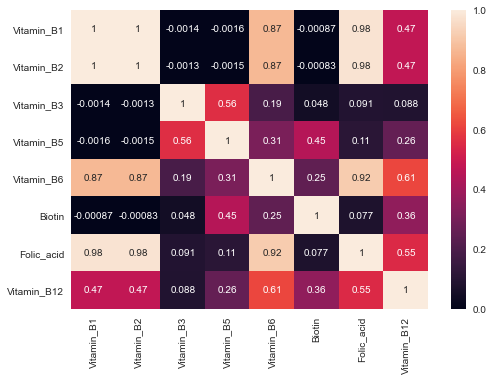

In [21]:
Bs = ['Vitamin_B1', 'Vitamin_B2', 'Vitamin_B3', 'Vitamin_B5', 'Vitamin_B6',  'Biotin', 'Folic_acid', 'Vitamin_B12']
vitamin_B = products.loc[:,Bs]
corrV = vitamin_B.corr()
sns.heatmap(corrV, annot=True)

From the graph we're concluding that the column we might want to take to represent the Vitamin B group is either Vitamin_B1, Vitamin_B3, Vitamin_B6 or Vitamin_B9 (Folic_acid). 

We chosed them by the number of correlations that are about>=0.8 - by the bright orange colour (we didn't considered Vitamin_B2 because as we can see, the correlation between Vitamin_B1 and Vitamin_B2 is 1).

Now, we'll choose which one of these columns it will be by these criteria:
- the one with the most higher correlations
- the one with the least lower correlations
- the one with the most products in it (the Vitamin with the most products in a better representetive of the data)
- the one with the biggest correlation with column we want to predict - price_per_100g

In [22]:
might_be_rep = ['Vitamin_B1', 'Vitamin_B3', 'Vitamin_B6', 'Folic_acid']
for rep in might_be_rep:
    column_1 = prices
    column_2 = products[rep]
    correlation = column_1.corr(column_2)
    print(rep, ": number of correlations that are greater than 0.8: ", (corrV[rep].sort_values(ascending=False)>0.8).sum())
    print(rep, ": number of correlations that are below or equal 0.2: ", (corrV[rep].sort_values(ascending=False)<=0.2).sum())
    print(rep, ": number of products that has value: ", products[rep].astype(bool).sum(axis=0))
    print("correlation between price_per_100g and ",rep,": ", correlation)

Vitamin_B1 : number of correlations that are greater than 0.8:  4
Vitamin_B1 : number of correlations that are below or equal 0.2:  3
Vitamin_B1 : number of products that has value:  6839
correlation between price_per_100g and  Vitamin_B1 :  0.01785033141469863
Vitamin_B3 : number of correlations that are greater than 0.8:  1
Vitamin_B3 : number of correlations that are below or equal 0.2:  6
Vitamin_B3 : number of products that has value:  6839
correlation between price_per_100g and  Vitamin_B3 :  -0.0041076097525681475
Vitamin_B6 : number of correlations that are greater than 0.8:  4
Vitamin_B6 : number of correlations that are below or equal 0.2:  1
Vitamin_B6 : number of products that has value:  6839
correlation between price_per_100g and  Vitamin_B6 :  0.030040150886635697
Folic_acid : number of correlations that are greater than 0.8:  4
Folic_acid : number of correlations that are below or equal 0.2:  3
Folic_acid : number of products that has value:  6839
correlation between pr

By the two firet criteria we have putted first, it seems that the columns we should take as a representetive for the Vitamin B group is the column of Vitamin_B6 - it has the biggest number of correlations that are greater than 0.8 (which is 5), and it has the smallest number of correlations that are below or equal 0.2 (which is 0). Although Vitamin_B6 dosen't have the biggest correlation between price_per_100g, it has the second biggest one, and the difference between them is not that big.

We thought that we had a problem - the fact that in the Vitamin_B6 there are only 265 products, which is less than 5 precent of our data (it's about three precents - dfprod has 7668 products).

So we tried a different approach - instead of choosing one column to be the representetive of all the group, we tried to merge between the difeerent Vitamin Bs. we gave more significance to Vitamin_B6 and the one's that were designated to be the representetives by this order: first Vitamin_B6, then Vitamin_B3 (who has the best correlation with the price per 100g, and the smallest number of correlations that are below or equal 0.2 as well). Afterwards there was be Vitamin_B9 (Folic_acid) with the next best correlation after the two before and the biggest number of correlations that are greater than 0.8 and then Vitamin_B1. Then there was be Vitamin_B12 ,who has the same number of greater than 0.8 correlations as Vitamin_B5, but fewer correlations that are below or equal 0.2. And last but not least were Biotin and Vitamin_B5 because we can see from the graph that the correlation between Biotin, Vitamin_B5 and the other of the Vitamins is low.

we tried a different combinations of the code that appears in the next window, but it seemed that anything we did made the correlation between the column we tried to create to the price_per_100g to get lower and lower.

In the End we decided to stick with the Vitamin_B6 as the representor of this group, except for Vitamin_B5, Biotin and Vitamin_B12 who had lower correlations with the rest of the Vitamin Bs' group, so we wanted to look further into them.

In [26]:
products['Partof_vitaminB'] = products['Vitamin_B6']
products = products.drop(['Vitamin_B6','Vitamin_B1','Vitamin_B2','Vitamin_B3','Folic_acid'], axis=1)

In [27]:
corr_matrix = products.corr()
corr_matrix['Vitamin_B12'].sort_values(ascending=False)

Vitamin_B12             1.000000
Partof_vitaminB         0.613192
Biotin                  0.359965
Vitamin_B5              0.257006
copper                  0.252972
                          ...   
Trans_fatty_acids      -0.010597
Of_which_added_sugar   -0.012984
Cholesterol            -0.014627
Carbohydrate_sugars    -0.015561
Teaspoons_of_sugar     -0.029171
Name: Vitamin_B12, Length: 73, dtype: float64

In [28]:
corr_matrix = products.corr()
corr_matrix['Vitamin_B5'].sort_values(ascending=False)
#coudln't find the connection between copper and b5, bt found: the need for vitamin B5 is reduced in a copper-deficient(https://www.traceelements.com/Docs/The%20Nutritional%20Relationships%20of%20Copper.pdf)

Vitamin_B5              1.000000
Vitamin_K.              0.486277
copper                  0.481449
Inositol                0.466317
Choline                 0.447913
                          ...   
Cholesterol            -0.010968
Trans_fatty_acids      -0.011093
Of_which_added_sugar   -0.012517
sodium                 -0.015372
Fats                   -0.030935
Name: Vitamin_B5, Length: 73, dtype: float64

In [29]:
corr_matrix = products.corr()
corr_matrix['Biotin'].sort_values(ascending=False)
#the only connection found between biotin and vitamin e is: both told to help with looks of skin and hair(https://www.everydayhealth.com/pictures/supplements-skin-hair/) 

Biotin                   1.000000
Vitamin_B5               0.446249
Vitamin_K.               0.402509
Vitamin_E.               0.394813
copper                   0.390171
                           ...   
Saturated_fatty_acids   -0.005698
Of_which_added_sugar    -0.007244
Proteins                -0.007313
Fats                    -0.008451
sodium                  -0.010015
Name: Biotin, Length: 73, dtype: float64

The highest correlation Vitamin_B12 has with anything is with the Partof_vitaminB column we made. Thus, we decided to can give up on this column as well(to be represented by the Partof_vitaminB column). Moreover, the highest correlations that Biotin and Vitamin_B5 has with any other feature is a week relationship (absolute value between 0.25 and 0.5).

Furthermore, because we such a succsess with choosing the representitive of the Vitamin B group, we decided we wanted to look for a correlation within all the vitamin groups.

In [32]:
products = products.drop(['Vitamin_B12'], axis = 1)
vitamins_lst=['Vitamin_C','Vitamin_K.','Vitamin_E.','Vitamin_A','Vitamin_D.' ,'Partof_vitaminB', 'Biotin', 'Vitamin_B5']
vitaminS = products.loc[:,vitamins_lst]
corrvl = vitaminS.corr()
corrvl['Vitamin_K.'].sort_values(ascending=False)

KeyError: "['Vitamin_B12'] not found in axis"

There isn't a particulater high correlation. There is a weak connection between them all, but we can attribute that to the fact that a lot of the times vitamin appears together in the same kinds of foods (such as fruits).

###### checking correlations between all the things that contains sugars (and Carbohydrate_sugars and Carbohydrate):

<AxesSubplot:>

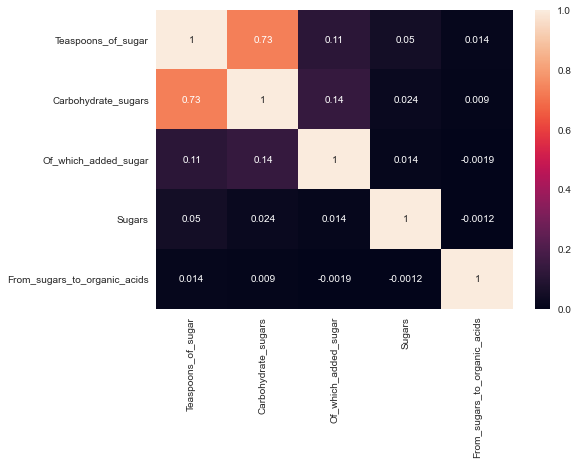

In [33]:
corr_matrix = products.corr()
Sm = ['Teaspoons_of_sugar', 'Carbohydrate_sugars', 'Of_which_added_sugar', 'Sugars', 'From_sugars_to_organic_acids']
Sugars_matix = products.loc[:,Sm]
corrS = Sugars_matix.corr()
sns.heatmap(corrS,annot=True)

From the graph we can see that the only strong correlation there is between Teaspoons_of_sugar and Carbohydrate_sugars, which is about 0.8.

The correlation between "Teaspoons of sugar" and "Carbohydrate sugars" is high, beacuse as we found at https://www.camoni.co.il/411804/559434, a nutritionist named Marina Broshi explained that Teaspoons of sugar = Carbohydrate sugars/4. 

Now, We'll check the correlation between Teaspoons_of_sugar, Carbohydrate_sugars and price_per_100g (in order to decide on which of the two columns we should give up), But before we'll decide to drop the Carbohydrate sugars (if it'll come to that) column we''ll check as well the correlation between Carbohydrates and Carbohydrate_sugars, as we wanted before.

In [34]:
column_1 = products["Carbohydrate_sugars"]
column_2 = products["Carbohydrates"]
correlation = column_1.corr(column_2)
print("correlation between Carbohydrates and Carbohydrate_sugars ", correlation)
column_1 = products["Carbohydrate_sugars"]
column_2 = products["Teaspoons_of_sugar"]
correlation = column_1.corr(column_2)
print("correlation between Carbohydrate_sugars and Teaspoons_of_sugar ", correlation)
column_1 = products["Carbohydrate_sugars"]
column_2 = prices
correlation = column_1.corr(column_2)
print("correlation between Carbohydrate_sugars and the price per 100g ", correlation)
column_1 = products["Teaspoons_of_sugar"]
column_2 = prices
correlation = column_1.corr(column_2)
print("correlation between Teaspoons of sugar and the price per 100g ", correlation)

correlation between Carbohydrates and Carbohydrate_sugars  0.4555297046536948
correlation between Carbohydrate_sugars and Teaspoons_of_sugar  0.7301588432352354
correlation between Carbohydrate_sugars and the price per 100g  0.02458429505014818
correlation between Teaspoons of sugar and the price per 100g  0.03584296067984085


The correlation between Carbohydrate_sugars and Teaspoons_of_sugar is indeed about 0.8 (0.73), and id higher than the correlation between Carbohydrates and Carbohydrate_sugars, which is due to the fact that in the labeling itself, some of the Carbohydrates are Carbohydrate_sugars (as we learn from LJ Amaral, R.D., a registered dietician in https://greatist.com/health/relationship-between-sugar-and-carbs#What-You-Need-to-Know-About-Sugar-and-Carbohydrates-). 

In every product there is a different amount of sugar, and thus the correlation between Carbohydrates and Carbohydrate_sugars is lower than the one between Carbohydrate_sugars and Teaspoons_of_sugar (where there is an exact formula to calculate the connection). 

Due to that, we decided to drop the Carbohydrate sugars column.

In [35]:
products = products.drop(['Carbohydrate_sugars'], axis=1)

###### checking correlations between energy and the rest of the nutrition values:

In [36]:
corr_matrix = products.corr()
corr_matrix["energy"].sort_values(ascending=False)
print(corr_matrix["energy"].sort_values(ascending=False))

energy                 1.000000
Fats                   0.755192
Carbohydrates          0.438575
Teaspoons_of_sugar     0.309344
Dietary_fiber          0.225631
                         ...   
Linoleic_fatty_acid   -0.049040
Vitamin_C             -0.052495
chlorine              -0.052922
ARA_fatty_acid        -0.056550
sodium                -0.116058
Name: energy, Length: 71, dtype: float64


The strong correlation between "energy" and "Fats" is high, beacuse as we found at wikipedia, https://he.wikipedia.org/wiki/%D7%A7%D7%9C%D7%95%D7%A8%D7%99%D7%94, energy, which is Calories can be calculated by: 1g of Fats=1g of energy*9 

In [37]:
column_1 = products["energy"]
column_2 = prices
correlation = column_1.corr(column_2)
print("correlation with energy ", correlation)
column_1 = products["Fats"]
column_2 = prices
correlation = column_1.corr(column_2)
print("correlation with Fats ", correlation)
products = products.drop(['energy'], axis=1) #the correlation with Fats is higher. thus, we'll drop the energy column

correlation with energy  0.03748325030418606
correlation with Fats  0.08301467929792974


###### checking correlations between the many kinds of fat: 
(we'll just point out that Linoleic_fatty_acid and Alpha_Linolenic_Acid are not the same fat acid. In they're compound, Linoleic_fatty_acid has 2 more hydrogen than Alpha_Linolenic_Acid)

Alpha_Linolenic_Acid(ALA)'s compound: C18H30O2 (https://en.wikipedia.org/wiki/Alpha-Linolenic_acid)

Linoleic_fatty_acid's compound: C18H32O2 (https://en.wikipedia.org/wiki/Linoleic_acid)

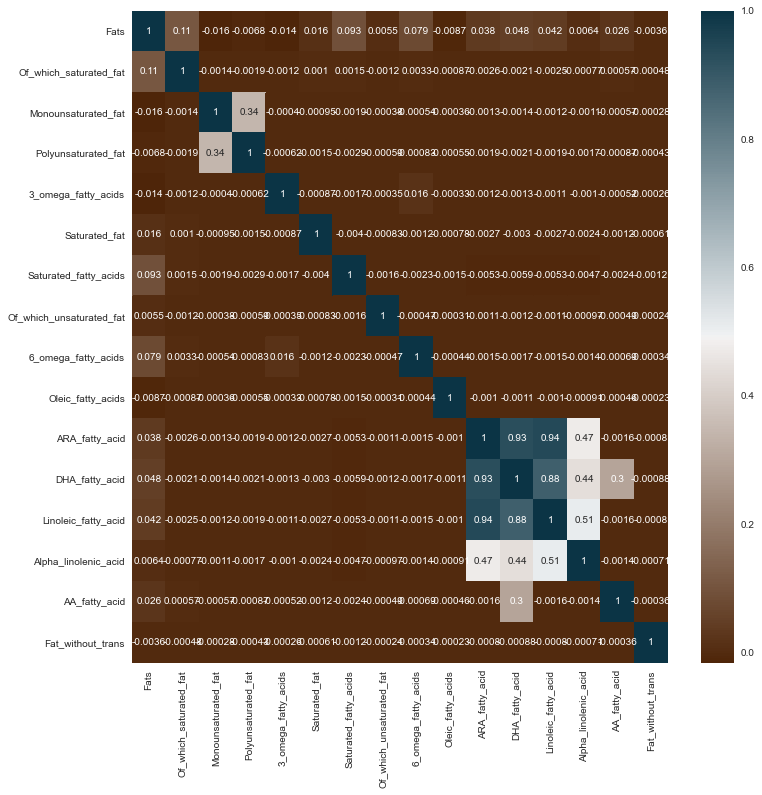

In [38]:
Ft = ['Fats','Of_which_saturated_fat','Monounsaturated_fat','Polyunsaturated_fat','3_omega_fatty_acids',
             'Saturated_fat','Saturated_fatty_acids','Of_which_unsaturated_fat','6_omega_fatty_acids','Oleic_fatty_acids'
             ,'ARA_fatty_acid', 'DHA_fatty_acid','Linoleic_fatty_acid','Alpha_linolenic_acid','AA_fatty_acid','Fat_without_trans']
Fats_list = products.loc[:,Ft]
cmap = sns.diverging_palette(30, 230, 90, 20, as_cmap=True)
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(Fats_list.corr(),annot=True, cmap=cmap)
sns.set(font_scale=1)

we can see from graph that there is an area with a high correlation between three features - ARA_fatty_acid, DHA_fatty_acid and Linoleic_fatty_acid. The higher correlations are with ARA_fatty_acid so we decided to dig further in the origins of ARA_fatty_acid. 

we found out that Linoleic acid, AA_fatty_acid, ARA_fatty_acid (apperaantly AA_fatty_acid and ARA_fatty_acid is the same fatty_acid) are subsets of 6_omega_fatty_acids https://en.wikipedia.org/wiki/Omega-6_fatty_acid

We decided to unite these columns, but not before we checked does some of the fats we have are subsets of 3_omega_fatty_acids. we descovered that DHA_fatty_acid together with ALA (which is Alpha_Linolenic_Acid) are subsets of 3_omega_fatty_acids.https://en.wikipedia.org/wiki/Omega-3_fatty_acid

Also, we found that there is a connection between linoleic acids and oleic acids.

In [39]:
products = merge_two_columns('6_omega_fatty_acids', 'AA_fatty_acid', products, 'Product_Name')
products = merge_two_columns('6_omega_fatty_acids', 'ARA_fatty_acid', products, 'Product_Name')
products = merge_two_columns('6_omega_fatty_acids', 'Linoleic_fatty_acid', products, 'Product_Name')
products = merge_two_columns('3_omega_fatty_acids', 'DHA_fatty_acid', products, 'Product_Name')
products = merge_two_columns('3_omega_fatty_acids', 'Alpha_linolenic_acid', products, 'Product_Name')

In [40]:
products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6839 entries, Belgian_lemon-flavored_waffle_for_school to Gluten-free_seed_baguette
Data columns (total 65 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Dietary_fiber                        6839 non-null   float64
 1   Proteins                             6839 non-null   float64
 2   Carbohydrates                        6839 non-null   float64
 3   Fats                                 6839 non-null   float64
 4   sodium                               6839 non-null   float64
 5   potassium                            6839 non-null   float64
 6   Vitamin_C                            6839 non-null   float64
 7   iron                                 6839 non-null   float64
 8   Vitamin_K.                           6839 non-null   float64
 9   Vitamin_E.                           6839 non-null   float64
 10  Magnesium                            6839

In [41]:
#products.corr()

In [42]:
#corr_matrix = products.corr()
#sns.heatmap(corr_matrix) #in order to see if there's anything else worth checking

In [43]:
#print(corr_matrix["Vitamin_A"].sort_values(ascending=False).head(15))
#didn't found the connection between the features, but:
#found a connection between taurine on toxicity of vitamin A in rats: https://www.sciencedirect.com/science/article/abs/pii/S0308814607005420
#found a comparison between chronic taurine and vitamin E plus selenium supplementations: https://pubmed.ncbi.nlm.nih.gov/12688428/
#found a rate studies of destruction of polyunsaturated fatty acids in vitro by chlorine-based disinfectants: https://pubmed.ncbi.nlm.nih.gov/1504266/

In [44]:
#dfprod = dfprod.reset_index()
#products

After we accomplished all of our goals from the beginning and in that preapered the data, we wanted to choose a performance measure. for a regression project, like ours there are a few performance measure RMSE.

RMSE means-



what we'll do to a new data coming into the system (such as the test set):
(first set two, then set 1):
and then we checked the dummy regressor score

In [45]:
def data_ready_version_2(data): 
    dataw = data.copy()
    dataw.replace('(^\s+|\s+$)', '', regex=True, inplace=True)
    dataw = dataw.set_index('Product_Name')
    
    
    columns_need_to_drop = np.array([])
    columns_need_to_drop = np.append(columns_need_to_drop, all_dropped_collumns)
    columns_need_to_drop = np.append(columns_need_to_drop, sts_dropped_collumns)
    columns_need_to_drop = set(columns_need_to_drop)
    
    
    dataw = dataw.drop(columns_need_to_drop, axis=1)
    
    
    for col in dataw.columns:  
        dataw[col] = pd.to_numeric(dataw[col], errors='coerce')
    dataw = dataw.fillna(0)

    
    
    unwanted_units = dataw[(dataw['100_g']==0) & (dataw['1_kg']==0)].index 
    dataw = dataw.drop(unwanted_units)
    dataw['1_kg'] = dataw['1_kg']/10
    dataw['price_per_100g'] = dataw['1_kg'] + dataw['100_g']
    dataw = dataw.drop(['100_g' ,'1_kg'], axis=1)
    
    
    dataw_notscaled2 = dataw.drop("price_per_100g", axis=1).iloc[:,2:26] 
    dataw_prices = dataw["price_per_100g"].copy()
    
    scaler.fit(products_notscaled2)
    dataw_scaledarr = scaler.fit_transform(dataw_notscaled2, products_notscaled2)
    dataw_scaled = pd.DataFrame(dataw_scaledarr, index=dataw_notscaled2.index, columns=dataw_notscaled2.columns)
    
    return dataw_scaled, dataw_prices

In [46]:
def data_ready_version_1(data): 
    dataw = data.copy()
    dataw.replace('(^\s+|\s+$)', '', regex=True, inplace=True)
    dataw = dataw.set_index('Product_Name')
    
    columns_need_to_drop = np.array([])
    columns_need_to_drop = np.append(columns_need_to_drop, all_dropped_collumns)
    columns_need_to_drop = np.append(columns_need_to_drop, sts_dropped_collumns)
    columns_need_to_drop = set(columns_need_to_drop)
    
    
    dataw = dataw.drop(columns_need_to_drop, axis=1)
    
    
    for col in dataw.columns:  
        dataw[col] = pd.to_numeric(dataw[col], errors='coerce')
    dataw = dataw.fillna(0)

    unwanted_units = dataw[(dataw['100_g']==0) & (dataw['1_kg']==0)].index 
    dataw = dataw.drop(unwanted_units)
    dataw['1_kg'] = dataw['1_kg']/10
    dataw['price_per_100g'] = dataw['1_kg'] + dataw['100_g']
    dataw = dataw.drop(['100_g' ,'1_kg'], axis=1)
    
    dataw_notscaled = dataw.drop("price_per_100g", axis=1) 
    dataw_prices = dataw["price_per_100g"].copy()
    
    scaler.fit(products_notscaled)
    dataw_scaledarr = scaler.fit_transform(dataw_notscaled, products_notscaled)
    dataw_products = pd.DataFrame(dataw_scaledarr, index=dataw_notscaled.index, columns=dataw_notscaled.columns)
    
    dataw_products = merge_two_columns('Vitamin_A', 'Vitamin_A_is_worth_retinol', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Dietary_fiber', 'Dietary_fiber.1', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('potassium', 'K_Potassium', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_E.', 'Vitamin_E_equals_alpha_tocopherol', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_D.', 'Vitamin_D_Calciprolol', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_B3', 'Niacin', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('Vitamin_B3', 'Vitamin_B3_Nicotinamide_Equilibrium', dataw_products, 'Product_Name')
    
    dataw_products['Partof_vitaminB'] = dataw_products['Vitamin_B6']
    dataw_products = dataw_products.drop(['Vitamin_B2', 'Vitamin_B6','Vitamin_B3','Folic_acid','Vitamin_B1','Vitamin_B12'
                              ,'Carbohydrate_sugars','energy'], axis=1)
    dataw_products = merge_two_columns('6_omega_fatty_acids', 'AA_fatty_acid', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('6_omega_fatty_acids', 'ARA_fatty_acid', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('6_omega_fatty_acids', 'Linoleic_fatty_acid', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('3_omega_fatty_acids', 'DHA_fatty_acid', dataw_products, 'Product_Name')
    dataw_products = merge_two_columns('3_omega_fatty_acids', 'Alpha_linolenic_acid', dataw_products, 'Product_Name')
    
    return dataw_products, dataw_prices

In [47]:
def RMSE(real, prediction):
    return np.sqrt(MSE(real, prediction))

In [48]:
#test_set_prod2, test_set_prices2 = data_ready_version_2(test_set)

In [49]:
#test_set_prod1, test_set_prices1 = data_ready_version_1(test_set)

In [50]:
'''dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(products, prices)
predictdum2 = dummy_regr.predict(test_set_prod2)
mser = RMSE(test_set_prices2, predictdum2)
print( "mean squered error of " + str(mser)[:4])'''

'dummy_regr = DummyRegressor(strategy="mean")\ndummy_regr.fit(products, prices)\npredictdum2 = dummy_regr.predict(test_set_prod2)\nmser = RMSE(test_set_prices2, predictdum2)\nprint( "mean squered error of " + str(mser)[:4])'

In [51]:
'''dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(products, prices)
predictdum1 = dummy_regr.predict(test_set_prod1)
mser = RMSE(test_set_prices1, predictdum1)
print( "mean squered error of " + str(mser)[:4])'''

'dummy_regr = DummyRegressor(strategy="mean")\ndummy_regr.fit(products, prices)\npredictdum1 = dummy_regr.predict(test_set_prod1)\nmser = RMSE(test_set_prices1, predictdum1)\nprint( "mean squered error of " + str(mser)[:4])'

(it make sense that for both of the preperations the score of the dummy regressor is the same beacuse we did scaling so there is an even distribution, so the score of mean is the same). 

# end of data cleaning

In [53]:
def maxN(elements, n):
    return sorted(elements, reverse=True)[:n]

In [56]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)
lin_reg = LinearRegression()
print(products.shape, prices.shape)
predict1 = cross_val_predict(lin_reg, products, prices, cv=10)
a=0
for i in predict1:
    print(i, a)
    a=a+1
print(maxN(predict1, 10))
rmse_linreg1 = RMSE(prices, predict1)
print(rmse_linreg1)

lin_reg = LinearRegression()
predict2 = cross_val_predict(lin_reg, products2, prices2, cv=10)
rmse_linreg2 = RMSE(prices2, predict2)
print(rmse_linreg2)

(6839, 65) (6839,)
7.515235900878906 0
6.830665588378906 1
6.822654724121094 2
6.634681701660156 3
6.787559509277344 4
7.875129699707031 5
5.308753967285156 6
4.138252258300781 7
6.362907409667969 8
7.319236755371094 9
7.718193054199219 10
7.249961853027344 11
6.642494201660156 12
6.341972351074219 13
11.085563659667969 14
4.619529724121094 15
7.347373962402344 16
6.848747253417969 17
4.611244201660156 18
9.019493103027344 19
7.801994323730469 20
6.736564636230469 21
7.421363830566406 22
6.931114196777344 23
7.036277770996094 24
6.563926696777344 25
15.489585876464844 26
6.506706237792969 27
8.669588088989258 28
6.899253845214844 29
6.227577209472656 30
8.942649841308594 31
12.152687072753906 32
6.988883972167969 33
8.798057556152344 34
6.777687072753906 35
9.539421081542969 36
6.826133728027344 37
6.763984680175781 38
6.557991027832031 39
4.871406555175781 40
6.838554382324219 41
8.337516784667969 42
6.426353454589844 43
6.419013977050781 44
5.651603698730469 45
6.725471496582031 46
6

9.650075275887334 1253
8.703023273934209 1254
5.928899128426397 1255
6.687230427254522 1256
5.688481647957647 1257
8.215627033699835 1258
6.754094440926397 1259
7.5048116040123345 1260
7.4160054516685845 1261
7.047765095223272 1262
11.30574544190296 1263
6.8958333325279595 1264
8.770482380379521 1265
7.948552448738897 1266
6.137547810067022 1267
9.404225666512334 1268
8.060216267098273 1269
6.906163532723272 1270
6.949620563973272 1271
7.263066608895147 1272
6.7128194165123345 1273
8.23592122315296 1274
6.7569783520592095 1275
7.9700520825279595 1276
6.8529866528404595 1277
6.323399860848272 1278
7.1880086254967095 1279
6.2542622876060845 1280
6.3596394848717095 1281
6.485049419502229 1282
3.405873615731084 1283
8.407140095223271 1284
-2.0165687619588537 1285
7.2960713696373345 1286
7.0619710278404595 1287
5.283940632332647 1288
8.313618977059209 1289
8.373082478035771 1290
12.21623326903042 1291
6.5973714184654595 1292
7.0342915844810845 1293
8.998372395027959 1294
7.1836140942467095 

13.989422657665209 2070
7.834225514110521 2071
7.922634937938646 2072
6.99621281879802 2073
6.502987721141771 2074
7.210217335399583 2075
8.596981861766771 2076
4.8941315199698945 2077
5.807919361766771 2078
3.29418645161052 2079
7.28051457661052 2080
8.604931690868334 2081
5.1247833754386445 2082
6.24567060246415 2083
10.005993702587082 2084
6.489453175243334 2085
8.765133717235521 2086
6.833889820751146 2087
5.839749195751146 2088
12.760464527782396 2089
6.556332447704271 2090
5.949642994579271 2091
5.605877735790209 2092
7.501095631298021 2093
6.870953419383959 2094
6.990521290477708 2095
9.559643604930832 2096
7.119717457469896 2097
9.023815968212084 2098
7.039349415477708 2099
9.668850758251144 2100
6.370510914501146 2101
7.781948902782396 2102
6.832516529735521 2103
7.562451222118334 2104
7.357693531688645 2105
7.026348927196459 2106
13.477005004020079 2107
12.67343285170742 2108
4.8174103285636445 2109
8.808255055126146 2110
8.463345387157396 2111
6.665661671337084 2112
8.447354

6.800557493332455 3054
7.369106671472486 3055
6.48459243577674 3056
7.411578796870485 3057
6.924713915707208 3058
7.457954999701752 3059
7.118439602585787 3060
9.356132588077646 3061
6.7992844037684 3062
7.801186549703022 3063
7.3317368618662675 3064
7.41163756607583 3065
6.842475919211531 3066
7.090280276019502 3067
7.193913745167626 3068
6.474550109029413 3069
5.513325618579519 3070
7.124190739734372 3071
6.385908746039843 3072
5.374145778023243 3073
10.190047565732204 3074
6.95050265677801 3075
8.351590592182239 3076
6.600260554002247 3077
18.62450429859546 3078
6.614425162995383 3079
6.639431051001874 3080
8.491665912141915 3081
7.045360207813521 3082
13.982108313985702 3083
9.562038873629152 3084
11.782377671874773 3085
7.150961681333723 3086
3.1108930827654495 3087
9.336310973734005 3088
5.997865314090507 3089
6.142176142999014 3090
6.601101576411461 3091
6.948644666746323 3092
12.311562026150582 3093
9.07407277359705 3094
7.6251090484782065 3095
7.584744778527781 3096
7.07111237

7.618547019626554 4026
8.741593894626554 4027
7.361375388767179 4028
5.215745505954679 4029
9.934175071384367 4030
7.792542991306242 4031
4.827577170993742 4032
6.208497581149992 4033
6.947999534274992 4034
9.517655906345304 4035
7.069245872165617 4036
14.217988547946863 4037
6.870576438571867 4038
6.806321677829679 4039
7.231568870212492 4040
8.351838645603117 4041
7.350877341892179 4042
6.954438743259367 4043
7.156480369235929 4044
4.586091575290617 4045
9.397065696384367 4046
6.034196433689054 4047
7.953340110446867 4048
7.501817283298429 4049
6.886537131931242 4050
6.314775046970304 4051
10.088349295160551 4052
6.956162986423429 4053
4.655198630954679 4054
7.844987449314054 4055
6.754334983493742 4056
6.284318504001554 4057
7.309251365329679 4058
5.319902000095304 4059
6.804688987399992 4060
9.405946311618742 4061
5.939363059665617 4062
6.829301414157804 4063
6.934205588962492 4064
5.214082297946867 4065
7.542237815524992 4066
7.696000632907804 4067
7.973100242282804 4068
6.0248275

7.147109163990282 4983
3.232924593677783 4984
5.343032015552781 4985
6.693740023365281 4986
7.060195101490281 4987
6.777724398365282 4988
7.412978304615282 4989
6.440322054615281 4990
6.809706820240282 4991
6.674086703052781 4992
7.319472445240282 4993
6.283827913990281 4994
8.020104859341798 4995
6.687514437427781 4996
9.633925570240283 4997
9.664321078052783 4998
6.189955843677781 4999
6.184218538990281 5000
7.746230257740281 5001
17.41310037492778 5002
7.652480257740282 5003
7.059096468677781 5004
6.852553499927782 5005
7.482192171802782 5006
6.409438265552781 5007
8.896742953052781 5008
9.291640413990283 5009
6.854994906177782 5010
8.180434359302781 5011
10.460102529983535 5012
7.234389437427781 5013
8.547884689480554 5014
6.137587679615281 5015
7.219252718677781 5016
5.356825960865281 5017
6.777846468677782 5018
5.855727328052781 5019
7.622206820240282 5020
7.945326937427781 5021
7.504164828052782 5022
6.729384554615282 5023
6.425917757740281 5024
8.382704867115281 5025
5.65736307

6.690891265869141 5938
4.435916900634766 5939
14.869312286376953 5940
6.818286895751953 5941
7.508626937866211 5942
5.191989898681641 5943
9.496829986572266 5944
8.295612335205078 5945
6.566928863525391 5946
6.252368927001953 5947
8.491336822509766 5948
9.08401870727539 5949
9.652545928955078 5950
6.428653717041016 5951
7.520618438720703 5952
7.167209625244141 5953
4.028125762939453 5954
6.989368438720703 5955
6.419559478759766 5956
4.812717437744141 5957
6.563419342041016 5958
6.694181442260742 5959
4.777011871337891 5960
5.331653594970703 5961
7.179248809814453 5962
6.788669586181641 5963
6.716632843017578 5964
7.942157745361328 5965
6.158008575439453 5966
6.838962554931641 5967
7.609210968017578 5968
8.475635528564453 5969
8.292158126831055 5970
7.765613555908203 5971
8.171192169189453 5972
6.839633941650391 5973
7.030185699462891 5974
10.12802505493164 5975
6.525028228759766 5976
7.905963897705078 5977
6.613529205322266 5978
9.254108428955078 5979
3.1447181701660156 5980
8.38782119

802.3618985836223


we can see that there are 2 outliers
tried to remove them but then there were 2 other outliers
couldn't find a reasonable explenation
it seems that linear regression is not a good model for this problem

In [57]:
tree_reg = DecisionTreeRegressor()

predicttree1 = cross_val_predict(tree_reg, products, prices, cv=kf)
rmse_score1 = RMSE(prices, predicttree1)
print(rmse_score1)

predicttree2 = cross_val_predict(tree_reg, products2, prices2, cv=kf)
rmse_score2 = RMSE(prices2, predicttree2)
print(rmse_score2)

9.62868989594941
8.938491411225503


In [58]:
random_for = RandomForestRegressor()
prodicrfor1 = cross_val_predict(random_for, products, prices, cv=kf)
rmsefor = RMSE(prices, prodicrfor1)
print(rmsefor)

random_for = RandomForestRegressor()
prodicrfor2 = cross_val_predict(random_for, products2, prices2, cv=kf)
rmsefor2 = RMSE(prices, prodicrfor2)
print(rmsefor2)

7.6986251215669625
7.237790301675841


In [59]:
from sklearn.model_selection import GridSearchCV

param_grid = [
 {'n_estimators': [3, 10, 30], 'max_features': [10, 20, 30, 40, 50]},
 {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [10, 20, 30, 40, 50]},
 ]
grid_search = GridSearchCV(random_for, param_grid, cv=5,
 scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(products, prices)
grid_search.best_params_

{'bootstrap': False, 'max_features': 20, 'n_estimators': 10}